<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino

This was built by following the 
## Classify objects by color tutorial
https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

## Setup Python Environment 

The next cell sets up the dependencies in required for the notebook, run it.

In [1]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
%tensorflow_version 2.x
!pip install tensorflow

Selecting previously unselected package xxd.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.4_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.4) ...
Setting up xxd (2:8.0.1453-1ubuntu1.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the Files tab
1. Drag `csv` files from your computer to the tab to upload them into colab.

# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the full connected neural network.



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import fileinput

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

CLASSES = [];

for file in os.listdir("/content/"):
    if file.endswith(".csv"):
        CLASSES.append(os.path.splitext(file)[0])
print(CLASSES)
CLASSES.sort()

SAMPLES_WINDOW_LEN = 1
NUM_CLASSES = len(CLASSES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)

inputs = []
outputs = []

# read each csv file and push an input and output
for class_index in range(NUM_CLASSES):
  objectClass = CLASSES[class_index]
  df = pd.read_csv("/content/" + objectClass + ".csv")
  columns = list(df)
  # get rid of pesky empty value lines of csv which cause NaN inputs to TensorFlow
  df = df.dropna()
  df = df.reset_index(drop=True)
   
  # calculate the number of objectClass recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_WINDOW_LEN)
  print(f"\u001b[32;4m{objectClass}\u001b[0m class will be output \u001b[32m{class_index}\u001b[0m of the classifier")
  print(f"{num_recordings} samples captured for training with inputs {list(df)} \n")

  # graphing
#  plt.rcParams["figure.figsize"] = (10,1)
#  pixels = np.array([df['0'],df['1'],df['2']],float)
#  pixels = np.transpose(pixels)
#  for i in range(num_recordings):
#    plt.axvline(x=i, linewidth=8, color=tuple(pixels[i]/np.max(pixels[i], axis=0)))
#  plt.show()
  
  #tensors
  output = ONE_HOT_ENCODED_CLASSES[class_index]
  for i in range(num_recordings):
    tensor = []
    row = []
    for c in columns:
      row.append(df[c][i])
    tensor += row
    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")
print(inputs_train)

TensorFlow version = 2.4.1

['3_ZONE', '2_ZONE', '4_ZONE', '0_ZONE', '1_ZONE']
0_ZONE class will be output 0 of the classifier
374 samples captured for training with inputs ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30'] 

1_ZONE class will be output 1 of the classifier
365 samples captured for training with inputs ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30'] 

2_ZONE class will be output 2 of the classifier
371 samples captured for training with inputs ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30'] 

3_ZONE class will be output 3 of the classifier
380 samples captured for training with inputs ['1', '2', '3', '4', '5

## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [3]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(30, activation='relu')) # relu is used for performance
#model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')) # softmax is used, because we only expect one class to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=100, batch_size=8, validation_data=(inputs_validate, outputs_validate))



Epoch 1/100
140/140 [==============================] - 1s 5ms/step - loss: 0.3215 - mae: 0.3224 - val_loss: 0.3144 - val_mae: 0.3144
Epoch 2/100
140/140 [==============================] - 0s 2ms/step - loss: 0.3188 - mae: 0.3196 - val_loss: 0.3144 - val_mae: 0.3144
Epoch 3/100
140/140 [==============================] - 0s 2ms/step - loss: 0.3184 - mae: 0.3193 - val_loss: 0.3144 - val_mae: 0.3144
Epoch 4/100
140/140 [==============================] - 0s 2ms/step - loss: 0.3187 - mae: 0.3190 - val_loss: 0.3144 - val_mae: 0.3144
Epoch 5/100
140/140 [==============================] - 0s 2ms/step - loss: 0.3181 - mae: 0.3204 - val_loss: 0.3144 - val_mae: 0.3144
Epoch 6/100
140/140 [==============================] - 0s 2ms/step - loss: 0.3227 - mae: 0.3236 - val_loss: 0.3155 - val_mae: 0.3155
Epoch 7/100
140/140 [==============================] - 0s 2ms/step - loss: 0.3223 - mae: 0.3237 - val_loss: 0.3283 - val_mae: 0.3283
Epoch 8/100
140/140 [==============================] - 0s 2ms/step - 

### Run with Test Data
Put our test data into the model and plot the predictions


predictions =
 [[0.    0.916 0.    0.084 0.   ]
 [0.    0.012 0.17  0.818 0.   ]
 [0.    0.017 0.396 0.585 0.001]
 ...
 [0.    0.    0.994 0.006 0.   ]
 [0.    0.015 0.008 0.978 0.   ]
 [0.    0.028 0.909 0.059 0.003]]
actual =
 [[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  if sys.path[0] == '':


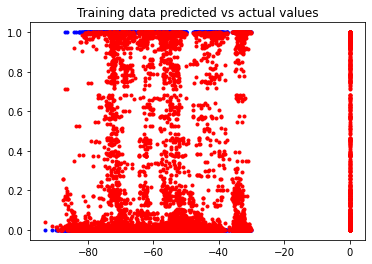

In [4]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
plt.plot(inputs_test, predictions, 'r.', label='Predicted')
plt.show()

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [5]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("locationAttempt_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("locationAttempt_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

INFO:tensorflow:Assets written to: /tmp/tmp15zz3nr7/assets
Model is 5720 bytes


## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [6]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat locationAttempt_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 35,308 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


# Realtime Classification of Sensor Data on Arduino

Now it's time to recompile with the newly created files